In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [2]:
# Load dataset
df = pd.read_csv("./dataset/Bengaluru_House_Data.csv")

# Display first few rows
df.head()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
# Clean column names: remove spaces, special chars, lowercase
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True)

print("Cleaned Column Names:\n", df.columns.tolist())


Cleaned Column Names:
 ['area_type', 'availability', 'location', 'size', 'society', 'total_sqft', 'bath', 'balcony', 'price']


In [5]:
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13320 non-null  object 
 3   size          13320 non-null  object 
 4   society       13320 non-null  object 
 5   total_sqft    13320 non-null  object 
 6   bath          13320 non-null  float64
 7   balcony       13320 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB
None
               bath       balcony         price
count  13320.000000  13320.000000  13320.000000
mean       2.688814      1.603378    112.565627
std        1.338754      0.803067    148.971674
min        1.000000      0.000000      8.000000
25%        2.000000      1.000000     50.000000
50%        2.000000      2.000000     72.000000
75%        3.000000     

In [6]:
#handle missing vals
# Fill missing numeric values with median
df['bath'].fillna(df['bath'].median(), inplace=True)
df['balcony'].fillna(df['balcony'].median(), inplace=True)

# Fill missing categorical values with mode
df['society'].fillna('Unknown', inplace=True)
df['location'].fillna('Other', inplace=True)


C:\Users\SHREYAS\AppData\Local\Temp\ipykernel_4540\3540549909.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bath'].fillna(df['bath'].median(), inplace=True)
C:\Users\SHREYAS\AppData\Local\Temp\ipykernel_4540\3540549909.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

In [7]:
df['bhk'] = df['size'].apply(lambda x: int(str(x).split(' ')[0]) if isinstance(x, str) else None)


In [8]:
def convert_sqft(x):
    try:
        # Handle range values like "2100 - 2850"
        if '-' in str(x):
            tokens = str(x).split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        # Handle normal numeric values
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)


In [9]:
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']


In [10]:
df['location'] = df['location'].apply(lambda x: x.strip())
location_stats = df['location'].value_counts(ascending=False)

# Replace locations that appear less than 10 times with "other"
df['location'] = df['location'].apply(lambda x: 'other' if location_stats[x] <= 10 else x)


In [11]:
# Removing price_per_sqft outliers
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df = remove_pps_outliers(df)


In [12]:
df = df[~(df['total_sqft'] / df['bhk'] < 300)]


In [13]:
le = LabelEncoder()
df['location'] = le.fit_transform(df['location'])


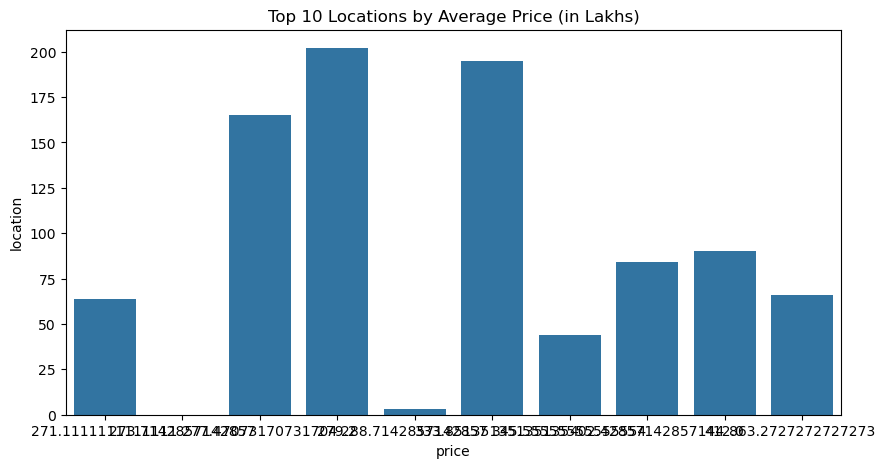

In [14]:
avg_price_location = df.groupby('location')['price'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='price', y='location', data=avg_price_location.head(10))
plt.title("Top 10 Locations by Average Price (in Lakhs)")
plt.show()


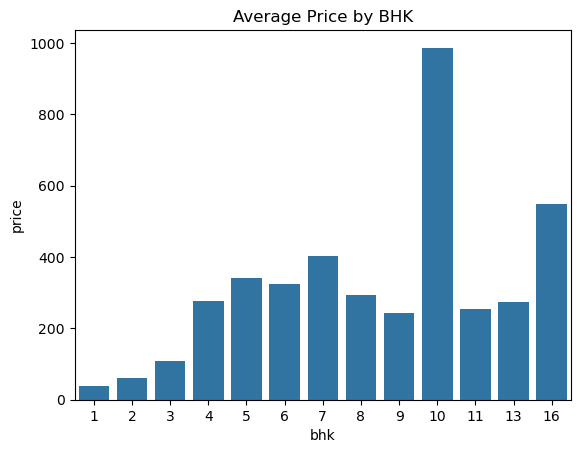

In [15]:
bhk_avg = df.groupby('bhk')['price'].mean().reset_index()
sns.barplot(x='bhk', y='price', data=bhk_avg)
plt.title("Average Price by BHK")
plt.show()


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['total_sqft', 'bath', 'balcony', 'price_per_sqft']] = scaler.fit_transform(df[['total_sqft', 'bath', 'balcony', 'price_per_sqft']])


In [17]:
df.to_csv("./dataset/Cleaned_Bengaluru_Housing.csv", index=False)
print("✅ Cleaned Bengaluru dataset saved as 'Cleaned_Bengaluru_Housing.csv'")


✅ Cleaned Bengaluru dataset saved as 'Cleaned_Bengaluru_Housing.csv'
